In [ ]:
#Preparing Kaggle API

from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#Download the dataset

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 93% 24.0M/25.7M [00:00<00:00, 60.1MB/s]
100% 25.7M/25.7M [00:00<00:00, 57.5MB/s]


In [ ]:
#Make directory and unzip the zipped datasets

!mkdir ./datasets
!unzip "imdb-dataset-of-50k-movie-reviews.zip" -d "datasets/"

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: datasets/IMDB Dataset.csv  


In [ ]:
#Import required library

import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#Read the dataset

df = pd.read_csv('datasets/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
#Map the label into one hot 

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
#Pick random samples

for i, row in df.sample(2, axis=0).iterrows():
  print('Review: ', row['review'])
  print('Sentiment: ', row['sentiment'])

Review:  A young ( only 21 ) director with great talent, a powerful scenario, young and ambitious cast with all theatrical background...<br /><br />One of the first tries of a thriller in Turkish cinema, which seems in the future we'll have some more based on the success...<br /><br />Shot on high definition video, the movie is perhaps effected on world thrillers, especially the American thrillers. The technical and cinematographic character is quite well done, the scenes are all well worked on. Not too much blood but sufficient enough to make you think you're in a blood bath too...<br /><br />The scenario is quite wise but with certain clues, a clever audience can easily predict what's going on and at the end when everything settles down you're getting somehow weird to conclude the result.<br /><br />Well done Tiglon, one of the biggest DVD distributors in Turkey, it is not easy to decide for such a movie in their first try as a production company...
Sentiment:  1
Review:  Every time 

In [ ]:
#Print the dataset

df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
#Split the dataset into 80% training and 20% testing

X_train, X_test, y_train, y_test = train_test_split(df['review'], 
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=23)

In [ ]:
#Prepare the stopwords used in this model

print('Please upload the stopwords: ')
f = files.upload()
for key in f:
  fname = key

with open(fname, 'r') as f:
  stopwords = json.loads(f.read())

Please upload the stopwords: 


Saving stopwords.txt to stopwords.txt


In [ ]:
#Function for cleaning text

def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-z]", ' ', text)
  word = [word for word in text.split() if word not in (stopwords)]
  text = ' '.join(word)
  return text
X_train = X_train.map(clean_text)
X_train

20198    enjoy films like american pie road trip van wi...
34103    seen lot greek feel suspicious felt astonished...
40179    seeing keifer sutherland plays favorite charac...
34586    take tired formula christmas comedy laughs tir...
30725    long time since last saw bad acting average st...
                               ...                        
9704     really shame much controversy surrounding pict...
11190    felt duty bound timothy dalton zelah clarke ad...
26569    point plot know shaq act people know direct ka...
9256     say reviews read little understanding original...
41555    got lured title expecting insightful intriguin...
Name: review, Length: 40000, dtype: object

In [ ]:
#Configuration of tokenizer and padding

config = {
    'vocab_size': 5000,
    'embedding_dim': 64,
    'max_len': 300,
    'trunc_type': 'post',
    'padding_type': 'post',
    'oov_token': '<OOV>',
}

In [ ]:
#Apply the tokenizer and padding into words

tokenizer = Tokenizer(num_words=config['vocab_size'], 
                      oov_token=config['oov_token'])
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, 
                             padding = config['padding_type'], 
                             truncating = config['trunc_type'],
                             maxlen = config['max_len'])
val_sequences = tokenizer.texts_to_sequences(X_test)
val_padded = pad_sequences(val_sequences, 
                           padding = config['padding_type'], 
                           truncating = config['trunc_type'],
                           maxlen = config['max_len'])

# from tensorflow.keras.preprocessing.text import tokenizer_from_json
# with open('tokenizer.json', 'r') as f:
#   tokenizer_json = json.load(f)
#   tokenizer = tokenizer_from_json(tokenizer_json)

# train_sequences = tokenizer.texts_to_sequences(X_train)
# train_padded = pad_sequences(train_sequences, 
#                              padding = config['padding_type'], 
#                              truncating = config['trunc_type'],
#                              maxlen = config['max_len'])
# val_sequences = tokenizer.texts_to_sequences(X_test)
# val_padded = pad_sequences(val_sequences, 
#                            padding = config['padding_type'], 
#                            truncating = config['trunc_type'],
#                            maxlen = config['max_len'])

In [ ]:
#Building the model

model = models.Sequential([
                           Embedding(config['vocab_size'], config['embedding_dim']),
                           Bidirectional(LSTM(32, return_sequences=True, dropout=0.2)),
                           GlobalMaxPool1D(),
                           Dense(16, activation='relu'),
                           Dropout(0.2),
                           Dense(1, activation='sigmoid')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         24832     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [ ]:
#Define the callback class

class Callback_Stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
      print("\nAccuracy and val_accuracy are above 85%, training progress will be stopped...")
      self.model.stop_training = True

In [ ]:
#Train the model

tf.keras.backend.clear_session()
seed = 23
tf.random.set_seed(seed)
np.random.seed(seed)
callback = Callback_Stop()
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])
history = model.fit(train_padded,
                    y_train,
                    epochs=10,
                    validation_data=(val_padded, y_test),
                    verbose=1,
                    steps_per_epoch = 50,
                    callbacks=[callback])

Epoch 1/10
50/50 [==============================] - 33s 494ms/step - loss: 0.6426 - accuracy: 0.6550 - val_loss: 0.6592 - val_accuracy: 0.6924
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8515
Accuracy and val_accuracy are above 85%, training progress will be stopped...
50/50 [==============================] - 23s 473ms/step - loss: 0.3665 - accuracy: 0.8515 - val_loss: 0.3096 - val_accuracy: 0.8718


In [ ]:
#Save the model

model.save('lstm-movie-review.h5')

In [ ]:
#Save the tokenizer

tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
  f.write(json.dumps(tokenizer_json))

In [ ]:
#Save the tokenizer and padding configurations

with open('configuration.json', 'w') as f:
  f.write(json.dumps(config))

### Test using newest IMDB Review from Hawkeye TV Series (2021)

In [ ]:
#Import required library for testing

import json
import re
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#Upload the constructed model

print('Please upload the models in h5 format: ')
f_model = files.upload()
for key in f_model:
  fname_model = key
reconstructed_model = tf.keras.models.load_model(fname_model)

Please upload the models in h5 format: 


Saving lstm-movie-review.h5 to lstm-movie-review.h5


In [ ]:
#Upload the stopwords

print('Please upload the stopwords: ')
f_stop = files.upload()
for key in f_stop:
  fname_stop = key

with open(fname_stop, 'r') as f:
  stopwords = json.loads(f.read())

Please upload the stopwords: 


Saving stopwords.txt to stopwords.txt


In [ ]:
#Upload the tokenizer and padding configurations

print('Please upload the configuration: ')
f_config = files.upload()
for key in f_config:
  fname_config = key

with open(fname_config, 'r') as f:
  config = json.loads(f.read())

Please upload the configuration: 


Saving configuration.json to configuration.json


In [ ]:
#Upload the tokenizer

print('Please upload the tokenizer: ')
f_token = files.upload()
for key in f_token:
  fname_token = key

with open(fname_token, 'r') as f:
  tokenizer_json = json.load(f)
  tokenizer = tokenizer_from_json(tokenizer_json)

Please upload the tokenizer: 


Saving tokenizer.json to tokenizer.json


In [ ]:
#Functin for cleaning words

def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-z]", ' ', text)
  word = [word for word in text.split() if word not in (stopwords)]
  text = ' '.join(word)
  return text

In [ ]:
#Function for predicting

def predict(model, text = str):
  temp = clean_text(text)
  test_sequences = tokenizer.texts_to_sequences(temp)
  flat_sequences = [[item for sublist in test_sequences for item in sublist]]
  test_padded = pad_sequences(flat_sequences, padding = config['padding_type'], 
                           truncating = config['trunc_type'],
                           maxlen = config['max_len'])
  pred = model.predict(test_padded)
  pred_fix = (pred > 0.5)*1
  label = 'The review is Positive with score '+str(pred) \
  if pred_fix[0][0] == 1 else 'The review is Negative with score '+str(pred)
  return label

In [ ]:
#Test positive review

text_test_pos = 'A must-watch the show which the audience deserved to see for a long time! Full of entertainment and feel-good show. The Christmas theme of this show is amazing. Loved it. The bond between Nat and Clint is explained so nicely. I was very emotional at the end when Yelena cried. This is a must-watch show that Hawkeye deserved and also the audience deserved to know this story for a long time.'
text_test_pos

'A must-watch the show which the audience deserved to see for a long time! Full of entertainment and feel-good show. The Christmas theme of this show is amazing. Loved it. The bond between Nat and Clint is explained so nicely. I was very emotional at the end when Yelena cried. This is a must-watch show that Hawkeye deserved and also the audience deserved to know this story for a long time.'

In [ ]:
#Predict the test text

review_pred_1 = predict(reconstructed_model, text_test_pos)
review_pred_1

'The review is Positive with score [[0.8011379]]'

In [ ]:
#Test negative review

text_test_neg = 'Wow, this show is bad on so many levels - the main being it is BORING AF. The show isn\'t even about Hawkeye. Wow...after two episodes I\'m out, not just for this series, but Disney+.'
text_test_neg

"Wow, this show is bad on so many levels - the main being it is BORING AF. The show isn't even about Hawkeye. Wow...after two episodes I'm out, not just for this series, but Disney+."

In [ ]:
#Predict the negative review

review_pred_2 = predict(reconstructed_model, text_test_neg)
review_pred_2

'The review is Negative with score [[0.44760698]]'

### Word Cloud


In [ ]:
#Import wordcloud library

from wordcloud import WordCloud

In [ ]:
#Filter the positive review

df_pos = df.loc[df['sentiment'] == 1]
df_pos

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
...,...,...
49983,"I loved it, having been a fan of the original ...",1
49985,Imaginary Heroes is clearly the best film of t...,1
49989,I got this one a few weeks ago and love it! It...,1
49992,John Garfield plays a Marine who is blinded by...,1


In [ ]:
#Filter the negative review

df_neg = df.loc[df['sentiment'] == 0]
df_neg

,review,sentiment
3,Basically there's a family where a little boy ...,0
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
10,Phil the Alien is one of those quirky films wh...,0
11,I saw this movie when I was about 12 when it c...,0
...,...,...
49994,This is your typical junk comedy.<br /><br />T...,0
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
#Open the stopwords

with open('stopwords.txt', 'r') as f:
  stopwords = json.loads(f.read())

(-0.5, 2999.5, 1499.5, -0.5)

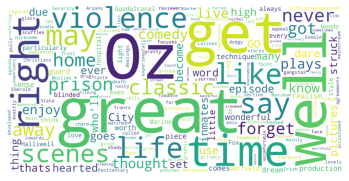

In [ ]:
#Print the positive review wordcloud

text_pos = df_pos['review'].values 

wordcloud = WordCloud(width = 3000, height = 1500,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 12).generate(str(text_pos))

plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 2999.5, 1499.5, -0.5)

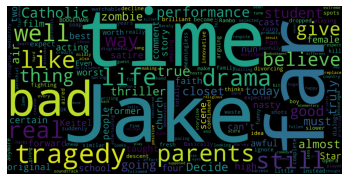

In [ ]:
#Print the negative review wordcloud

text_neg = df_neg['review'].values 

wordcloud = WordCloud(width = 3000, height = 1500,
                      background_color ='black',
                      stopwords = stopwords,
                      min_font_size = 15).generate(str(text_neg))

plt.imshow(wordcloud)
plt.axis("off")